In [76]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import dateutil
import json

In [197]:
%matplotlib inline
import pylab as plt

/Users/casy/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [235]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/1XmcuQM1DUPL9rIwnGJIJ26qI7sm3gOSPIk0Z01F7q-o/pub?output=csv')

In [237]:
df['link'] = df.link.str.replace('/?taken-by=archianya','')

In [238]:
df.head(4)

,text,img,link
0,"to dabble in - заниматься чем-либо как хобби, ...",https://scontent-lga3-1.cdninstagram.com/t51.2...,/p/BI6IhzGAkrm/?
1,"Credulous (kreh juh luhs) - too trusting, gull...",https://scontent-lga3-1.cdninstagram.com/t51.2...,/p/BIx2eFaAf5g/?
2,"Kerfuffle [kərˈfəfəl] - a commotion or fuss, e...",https://scontent-lga3-1.cdninstagram.com/t51.2...,/p/BIiEr_nAqwL/?
3,"When André asked to clean the windshield, the ...",https://scontent-lga3-1.cdninstagram.com/t51.2...,/p/BIWUiQwAoEk/?


In [239]:
df.shape

(312, 3)

In [240]:
def getInfo(link, sleep=1):
    '''gets info for photo: date, likes, comments'''
    if sleep is not None and sleep is int:
        time.sleep(sleep)
    
    try:
        
        url = 'https://www.instagram.com{}'.format(link)
        c = requests.get(url).text
        soup = BeautifulSoup(c)

        raw_date = soup.find_all("meta")[9]['content'].split(u'â¢ ')[1]
        date = dateutil.parser.parse(raw_date)

        raw_likes = soup.find_all("meta")[11]['content'] 
        if u'â¢ ' in raw_likes:
            likes = int(raw_likes.split(u'â¢ ')[1].split()[0])
        else:
            likes = 0

        raw_comments = soup.find_all('script', {'type':"text/javascript"})[4].text[21:-1]
        d = json.loads(raw_comments)

        comments = int(d['entry_data']['PostPage'][0]['media']['comments']['count'])
        return {'link':link, 'date':date, 'likes':likes, 'comments':comments}
    
    except Exception, e:
        print link, str(e)

In [241]:
infos = df.link.apply(getInfo).tolist()

In [266]:
result = {k:[x[k] for x in infos] for k in infos[0].keys()}

In [267]:
additional = pd.DataFrame(result)

In [272]:
df2 = df.merge(additional, on='link', how='left').set_index('date')

In [273]:
df2.head()

,text,img,link,comments,likes
date,,,,,
2016-08-10 00:37:00+00:00,"to dabble in - заниматься чем-либо как хобби, ...",https://scontent-lga3-1.cdninstagram.com/t51.2...,/p/BI6IhzGAkrm/?,1,127
2016-08-06 19:26:00+00:00,"Credulous (kreh juh luhs) - too trusting, gull...",https://scontent-lga3-1.cdninstagram.com/t51.2...,/p/BIx2eFaAf5g/?,4,97
2016-07-31 16:22:00+00:00,"Kerfuffle [kərˈfəfəl] - a commotion or fuss, e...",https://scontent-lga3-1.cdninstagram.com/t51.2...,/p/BIiEr_nAqwL/?,4,125
2016-07-27 02:50:00+00:00,"When André asked to clean the windshield, the ...",https://scontent-lga3-1.cdninstagram.com/t51.2...,/p/BIWUiQwAoEk/?,7,131
2016-07-26 01:11:00+00:00,André failed to take pictures for Instagram: t...,https://scontent-lga3-1.cdninstagram.com/t51.2...,/p/BITkgg8g2Lc/?,0,105


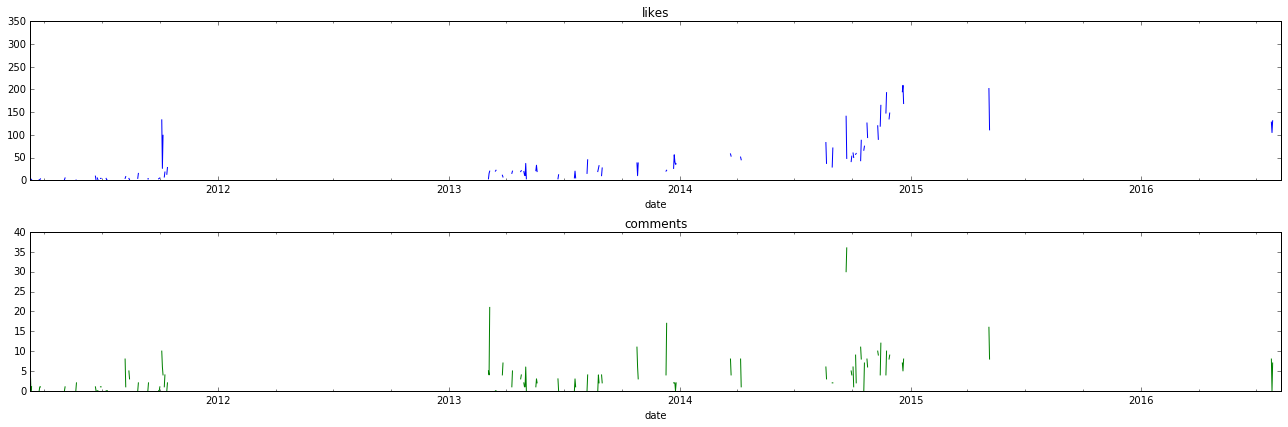

In [280]:
fig, axes = plt.subplots(2, 1, figsize=(18,6))
df2['likes'].resample('D').sum().plot(ax=axes[0])
df2['comments'].resample('D').sum().plot(ax=axes[1],  c='green' )  # 

axes[0].set_ylim(0, 350)
axes[0].set_title('likes')
axes[1].set_title('comments')
#plt.suptitle("Anna's Instagram metrics", fontsize=20)
plt.tight_layout()
